In [11]:

import json
import yaml

    
def dict_array_upend(mydict,key,elem):
    if key not in mydict:
        mydict[key]=[]
    mydict[key.append(elem)]

def load_sensor_log_file(fname):
    response=[]
    first_timestamp=0
    f=open(fname,'r')
    for line in f.readlines():        
        dat=json.loads(line)
        timestamp=dat["timestamp"]-first_timestamp
        response.append(dat)
        if first_timestamp==0:                        
            first_timestamp=timestamp
    return response,first_timestamp
        
sensor_log,first_timestamp=load_sensor_log_file("../to_study/caterpillar_test.txt")

In [12]:
import sys, os
#path2add = os.path.normpath(os.path.abspath(os.path.join(os.path.dirname(__file__), os.path.pardir, 'dir1')))
#print(os.getcwd())
parent_path = os.path.normpath(os.path.abspath(os.path.join(os.getcwd(), os.path.pardir)))
#print(path2add)
sys.path.append(parent_path)
sys.path.append(os.path.normpath(os.path.join(parent_path,"gyrii")))

from TimeSeries import TimeSeries

class SensorPlotter:
    def __init__(self):
        self.sensors=["position_sensor/gyro","position_sensor/b_field","position_sensor/acceleration","drive/motors_active"]
        self.bounds={}
        self.bounds["position_sensor/gyro"]=[-10,10]
        self.bounds["position_sensor/b_field"]=[-1000,1000]
        self.bounds["position_sensor/acceleration"]=[-20,20]
        ...
        self.sensor_timeseries={}
        self.first_timestamp=None
        
    def read_message(self,message):
        timestamp=message["timestamp"]
        if self.first_timestamp==None:
            self.first_timestamp=timestamp
        sensor="blah"
        for sensor in self.sensors:
            if sensor in message:
                if sensor not in self.sensor_timeseries:
                    self.sensor_timeseries[sensor]=[]
                    for k in range(len(message[sensor])):
                        self.sensor_timeseries[sensor].append(TimeSeries(title="{}_{}".format(sensor,k)))                                                    
                for k in range(len(message[sensor])):
                    if sensor in self.bounds:
                        if message[sensor][k] is not None and message[sensor][k]<self.bounds[sensor][1] and message[sensor][k]>self.bounds[sensor][0]:
                            self.sensor_timeseries[sensor][k].append(message["timestamp"]-self.first_timestamp,message[sensor][k])
                    else:
                        self.sensor_timeseries[sensor][k].append(message["timestamp"],message[sensor][k])
                    
    
plotter=SensorPlotter()

for i in range(len(sensor_log)):
    plotter.read_message(sensor_log[i])
    
    

C:\Users\grybk\projects\gratbot\gratbot_client\TimeSeries.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\grybk\projects\gratbot\gratbot_client\TimeSeries.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\grybk\projects\gratbot\gratbot_client\TimeSeries.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\grybk\projects\gratbot\gratbot_client\TimeSeries.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\grybk\projects\gratbot\gratbot_client\TimeSeries.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab

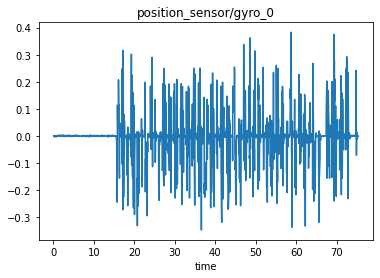

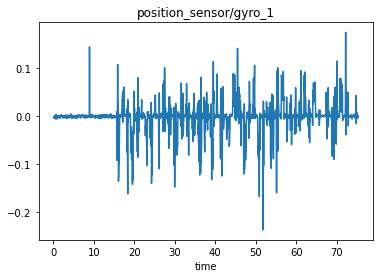

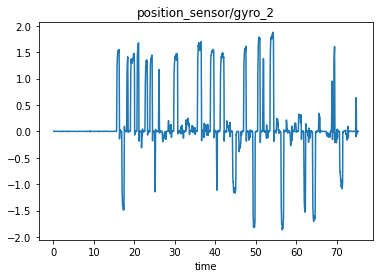

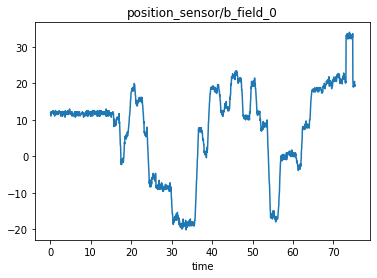

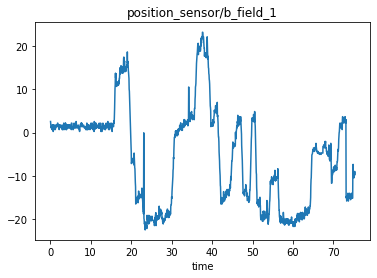

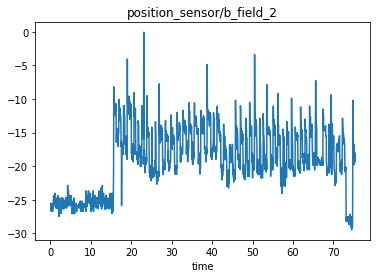

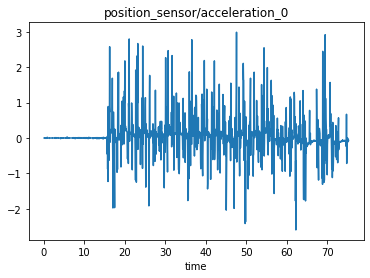

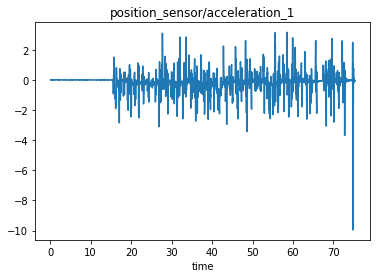

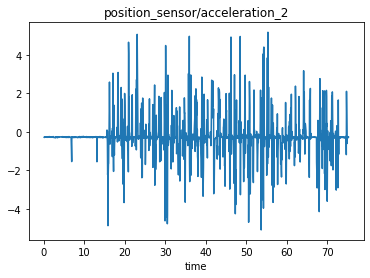

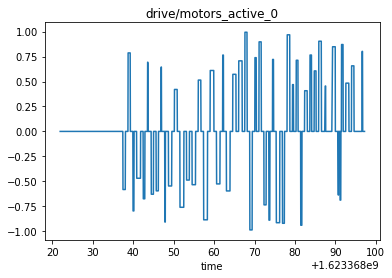

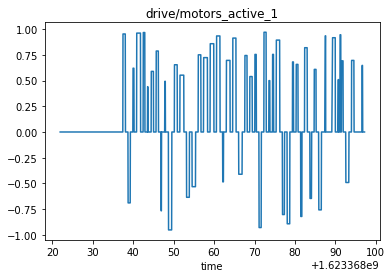

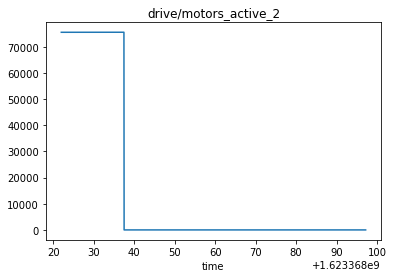

In [13]:
import numpy as np
import matplotlib.pyplot as plt
for s in plotter.sensor_timeseries.keys():
    for k in range(len(plotter.sensor_timeseries[s])):
        plotter.sensor_timeseries[s][k].plot()
        
d=plotter.sensor_timeseries["position_sensor/acceleration"][0].data
out=[]
f=10
for i in range(len(d)-f):
    out.append(np.sum(d[i:i+f])/f)
    
#plt.figure()
#plt.plot(out)
#plt.show()

In [4]:
import numpy as np
import torch

class SensorMessageToVector:
    def __init__(self):
        self.sensors=["position_sensor/gyro","position_sensor/b_field","position_sensor/acceleration","drive/motors_active"]
        self.bounds={}
        self.bounds["position_sensor/gyro"]=[-10,10]
        self.bounds["position_sensor/b_field"]=[-1000,1000]
        self.bounds["position_sensor/acceleration"]=[-20,20]
        self.usable={}
        self.usable["position_sensor/gyro"]=3
        self.usable["position_sensor/b_field"]=3
        self.usable["position_sensor/acceleration"]=3
        self.usable["drive/motors_active"]=2
        self.norms={}
        self.norms["position_sensor/gyro"]=1
        self.norms["position_sensor/b_field"]=20
        self.norms["position_sensor/acceleration"]=4
        self.norms["drive/motors_active"]=1
        
        ...
        self.sensor_timeseries={}
        self.first_timestamp=None
        
    def read_message(self,message):
        timestamp=message["timestamp"]
        if self.first_timestamp==None:
            self.first_timestamp=timestamp                
        if self.sensors[0] not in message:
            return None #all must be present        
        ret_vec=[]
        for sensor in self.sensors:
            if sensor in self.bounds:
                for k in range(len(message[sensor])):
                    if message[sensor][k] is None or message[sensor][k]>self.bounds[sensor][1] or message[sensor][k]<self.bounds[sensor][0]:
                        return None #misread
            #normalize here
            vector=np.array(message[sensor][0:self.usable[sensor]])/self.norms[sensor]                        
            ret_vec.extend(vector.tolist())
        return ret_vec
    
entries=[]

mtv=SensorMessageToVector()
last_tick=0
tick_every=0.05
cut_before_time=5.0
for s in sensor_log:
    t=s["timestamp"]-sensor_log[0]["timestamp"]
    if t<cut_before_time:
        continue
    while t-last_tick>tick_every:
        entries.append(["clock_tick",torch.tensor([tick_every]).float()])
        last_tick=last_tick+tick_every
    v=mtv.read_message(s)
    if v is not None:
        entries.append(["sensor_update",torch.tensor(v).float()])
    else:
        if "motor_command" in s:
            entries.append(["motor_command",torch.tensor(s["motor_command"]["lr_throttle"]).float()])
print("total entries {}".format(len(entries)))
print("which I guess is {} seconds".format(len(entries)/40))
#print("entry 1 length is {}".format(len(entries[0][1])))        
#print("entry 2 length is {}".format(len(entries[1][1])))
#print("entry 3 length is {}".format(len(entries[2][1])))


total entries 2936
which I guess is 73.4 seconds


In [5]:
import random

#cuda = torch.device('cuda') 


def generate_chunks():
    training_chunks=[]
    n_chunks=10
    chunk_size=20
    for i in range(n_chunks):
        start_bin=random.randrange(0,len(entries)-chunk_size)
        training_chunks.append( entries[start_bin:start_bin+chunk_size])
    return training_chunks
    
    

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from tqdm import tqdm

class UnbinnedTimeSeriesPredictor(nn.Module):
    def __init__(self,hidden_size):
        super(UnbinnedTimeSeriesPredictor, self).__init__()
        self.params=nn.ParameterList()
        #self.memory_size=memory_size
        #self.used_memory_size=0
        self.hidden_size=hidden_size
        self.update_networks={} 
        #self.memory_start_address={} #start addres and size
        #dictionary of networks that apply changes to hidden layer
        #so they have and input dimension of hidden_size+sensor_input_vector_size 
        #and an output dimension of hidden_size
        self.prediction_networks={}
        #dictionary of networks that predict what the next sensor measurement should be
        #input dimension of hidden_size, output dimension of sensor_input_vector_size        
        
    def update(self,label,sensor_vec,hidden_vec):
        #Update with sensor measurement 'label'
        #return the new hidden value
        #print("sensor vec shape {}".format(sensor_vec.shape))
        #print("hidden vec shape {}".format(hidden_vec.shape))
        input_vector=torch.unsqueeze(torch.cat((hidden_vec,sensor_vec),0),0)
     
        #new_memory_vec=memory_vec
        #if label in self.memory_start_address:
#            i=self.memory_start_address[label][0]
#            new_memory_vec[i:i+self.memory_start_address[label][1]]
        #print("input vec shape {}".format(input_vector.shape))
        #print("new memory shape {}".format(new_memory_vec.shape))
        return self.update_networks[label](input_vector)[0]
        
    def predict(self,label,hidden_vec):
        #predict the value of sensor reading 'label'
        #return the senser prediction        
        return self.prediction_networks[label](torch.unsqueeze(hidden_vec,0))[0]
    
    def add_update_network(self,label,module,sensor_size):
        self.update_networks[label]=module
        self.params.extend(module.parameters())
        #if should_memorize:
#            self.memory_start_address[label]=[self.used_memory_size,sensor_size]
#            self.used_memory_size+=sensor_size  
        
    def add_prediction_network(self,label,module):
        self.prediction_networks[label]=module
        self.params.extend(module.parameters())
        

class OneLayerUpdate(nn.Module):
    def __init__(self,hidden_size,sensor_size,unity=False):
        super(OneLayerUpdate, self).__init__()
#        self.net=nn.Linear(hidden_size+sensor_size,hidden_size)
        self.linear_layer=nn.Linear(hidden_size+sensor_size,hidden_size)
        self.net=nn.Sequential(self.linear_layer,
                                nn.Tanh())
        if unity:
            with torch.no_grad():
                for i in range(hidden_size):
                    for j in range(hidden_size):
                        if i==j:
                            self.linear_layer.weight[i,j]=1.0+random.uniform(-0.05,0.05)
                        else:
                            self.linear_layer.weight[i,j]=random.uniform(-np.sqrt(0.05),np.sqrt(0.05))/hidden_size
        
        
    def forward(self,x):
        return self.net(x)     
    
class TwoLayerUpdate(nn.Module):
    def __init__(self,hidden_size,sensor_size,midlayer_size):
        self.midlayer_size=midlayer_size
        super(TwoLayerUpdate, self).__init__()
#        self.net=nn.Linear(hidden_size+sensor_size,hidden_size)
        #self.linear_layer=nn.Linear(hidden_size+sensor_size,hidden_size)
        self.net=nn.Sequential(nn.Linear(hidden_size+sensor_size,midlayer_size),
                               nn.Tanh(),
                               nn.Linear(midlayer_size,hidden_size),
                               nn.Tanh())     
        
    def forward(self,x):
        return self.net(x)     

#sensor_size=len(entries[0][1])
#memory_size=11
sensor_size=11
hidden_size=11
predictor=UnbinnedTimeSeriesPredictor(hidden_size)
predictor.add_update_network("sensor_update",OneLayerUpdate(predictor.hidden_size,sensor_size),sensor_size)
predictor.add_update_network("motor_command",OneLayerUpdate(predictor.hidden_size,2),2)
#predictor.add_update_network("sensor_update",TwoLayerUpdate(predictor.hidden_size,sensor_size,11),sensor_size)
predictor.add_update_network("clock_tick",OneLayerUpdate(predictor.hidden_size,1,unity=True),1)
predictor.add_prediction_network("sensor_update",nn.Linear(predictor.hidden_size,sensor_size))
#predictor.add_prediction_network("sensor_update",nn.Sequential(nn.Linear(predictor.hidden_size,sensor_size),nn.Tanh(),nn.Linear(sensor_size,sensor_size)))


In [7]:

def train_predictor(predictor,training_chunks,n_epochs):      
    start_predicting=5
    loss_function = torch.nn.MSELoss()
    loss_record=[]
    optimizer = optim.Adam(predictor.parameters(), lr=0.001)


    for epoch in tqdm(range(n_epochs)):
        targets=[]
        predictions=[]
        for chunk in training_chunks:
            hidden=torch.zeros(predictor.hidden_size)
            #hidden=hidden.to(cuda)
            #memory=torch.zeros(predictor.memory_size)

            for i in range(len(chunk)):
                #print(memory)
                #print(hidden)
                #print("on chunk {}".format(chunk[i]))
                if i>start_predicting and chunk[i][0] in predictor.prediction_networks:                    
                    targets.append(chunk[i][1])
                    predictions.append(predictor.predict(chunk[i][0],hidden))                    
                hidden=predictor.update(chunk[i][0],chunk[i][1],hidden)
        targets=torch.stack(targets)
        predictions=torch.stack(predictions)        
        loss=loss_function(predictions,targets)
        loss_record.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss_record

def test_predictor(predictor,dataset):
    #predictor.to(cuda)
    #for i in range(len(dataset)):
#        dataset[i][1].to(cuda)
    
    start_predicting=5
    hidden=torch.zeros(predictor.hidden_size)
    #hidden.to(cuda)
    #memory=torch.zeros(predictor.memory_size)
    targets=[]
    predictions=[]
    hiddens=[]
    for i in range(len(dataset)):
        if i>start_predicting and dataset[i][0] in predictor.prediction_networks:                    
            targets.append(dataset[i][1])
            predictions.append(predictor.predict(dataset[i][0],hidden))            
        hidden=predictor.update(dataset[i][0],dataset[i][1],hidden)
        hiddens.append(hidden)
    targets=torch.stack(targets)
    predictions=torch.stack(predictions)
    hiddens=torch.stack(hiddens)
    for i in range(hiddens.shape[1]):
        fig, ax = plt.subplots()
        plt.title("Hidden {}".format(i))
        ax.plot(hiddens[:,i].detach().numpy())        
        plt.show()
        
    for i in range(targets.shape[1]):
        fig, ax = plt.subplots()
        plt.title("Param {}".format(i))
        t=targets[:,i].detach().numpy()
        p=predictions[:,i].detach().numpy()
        print("Param {} loss = {}".format(i,np.linalg.norm(t-p)))
        ax.plot(t,'*')
        ax.plot(p)
        plt.show()
        



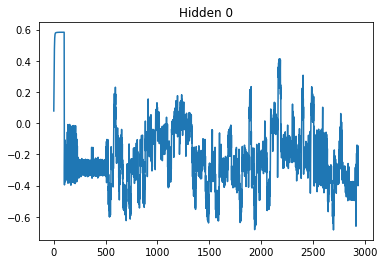

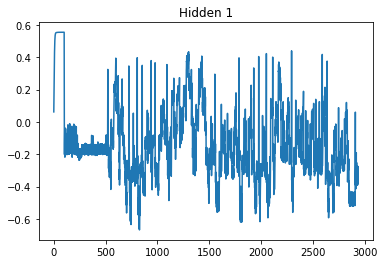

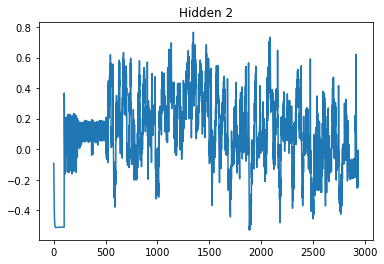

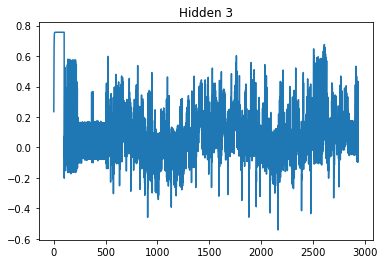

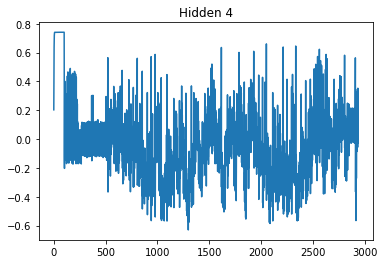

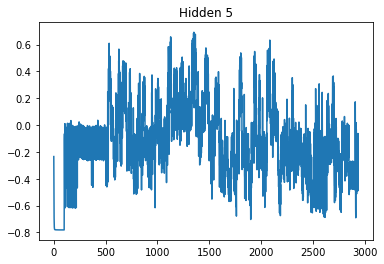

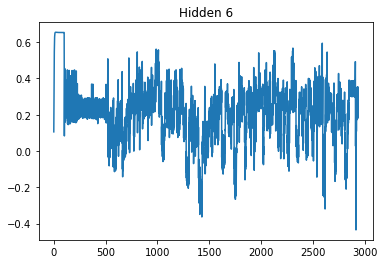

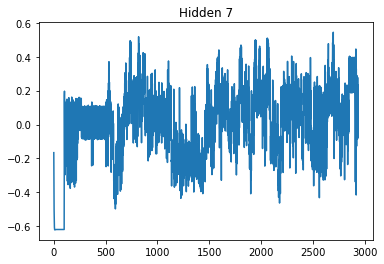

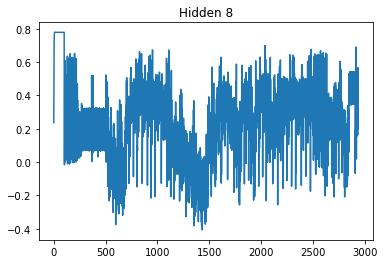

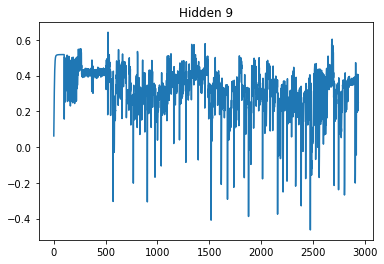

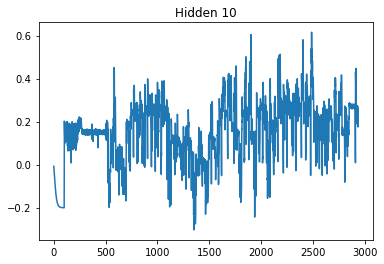

Param 0 loss = 4.819963455200195


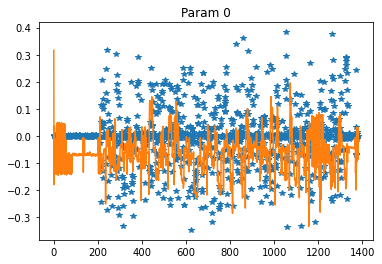

Param 1 loss = 5.060441493988037


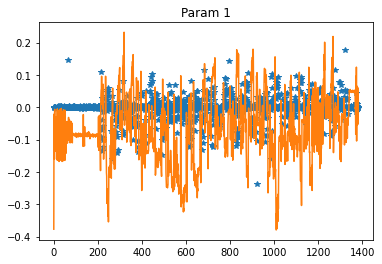

Param 2 loss = 23.47840118408203


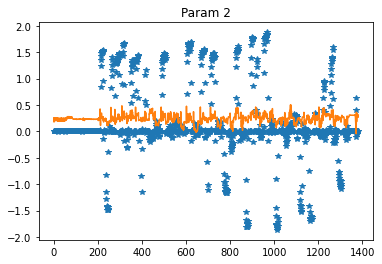

Param 3 loss = 37.70174789428711


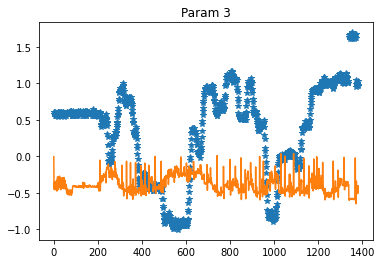

Param 4 loss = 24.533634185791016


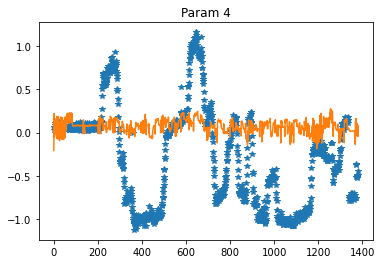

Param 5 loss = 31.62334442138672


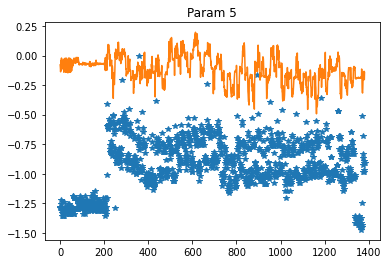

Param 6 loss = 7.430785179138184


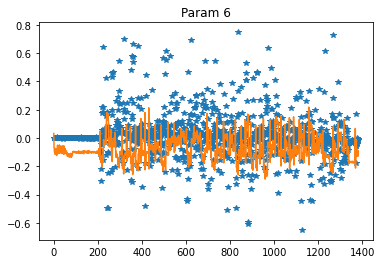

Param 7 loss = 9.508338928222656


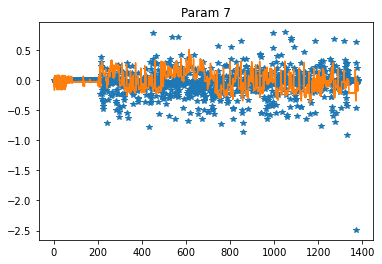

Param 8 loss = 12.818686485290527


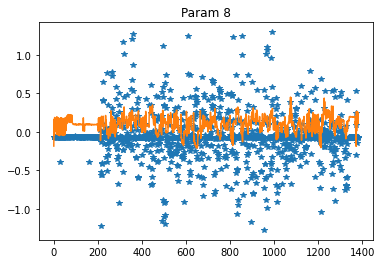

Param 9 loss = 18.621360778808594


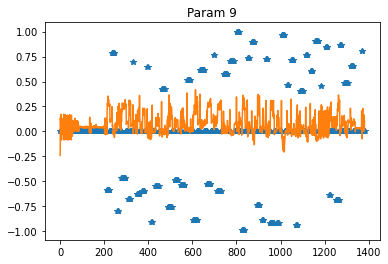

Param 10 loss = 16.80034637451172


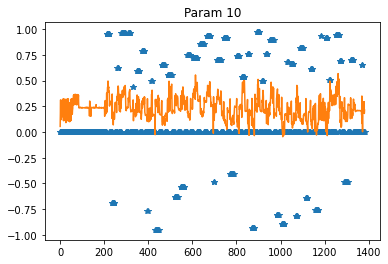

In [8]:
#for u in predictor.update_networks.keys():
#    predictor.update_networks[u].to(cuda)

test_predictor(predictor,entries)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 48.56it/s]


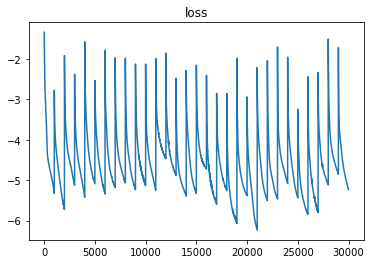

In [9]:
#predictor=predictor.to(cuda)
#cuda_training_chunks=[]
#for t in training_chunks:
#    on_chunk=[]
#    for i in range(len(t)):
#        on_chunk.append([t[i][0],t[i][1].to(cuda)])
#    cuda_training_chunks.append(on_chunk)
    
loss_record=[]
for j in range(30):
    loss_record.extend(train_predictor(predictor,generate_chunks(),1000))
#loss_record=train_predictor(predictor,cuda_training_chunks,2000)

fig, ax = plt.subplots()
plt.title("loss")
ax.plot(np.log(loss_record))
plt.show()

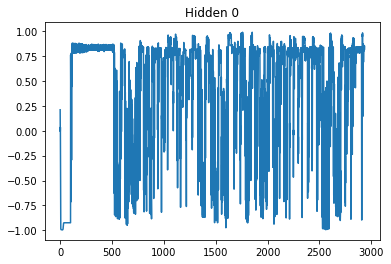

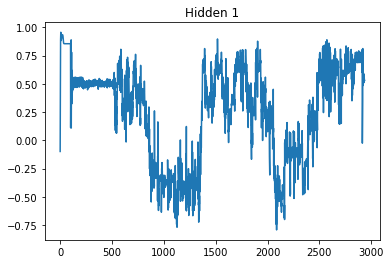

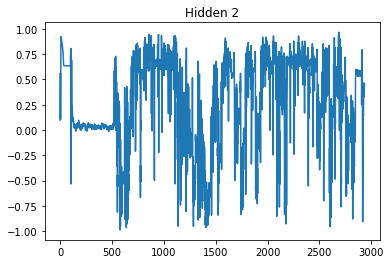

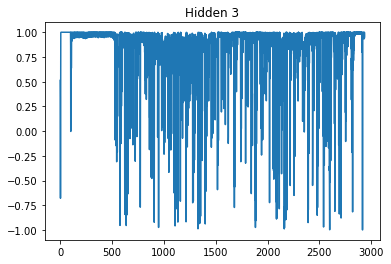

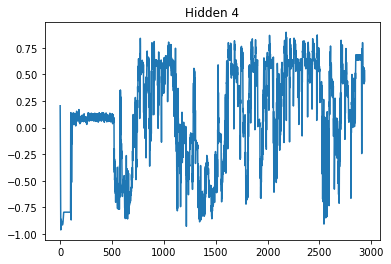

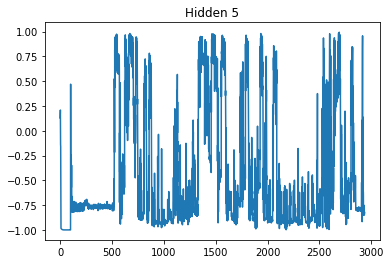

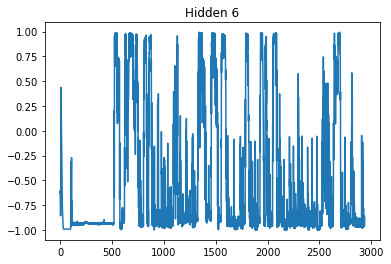

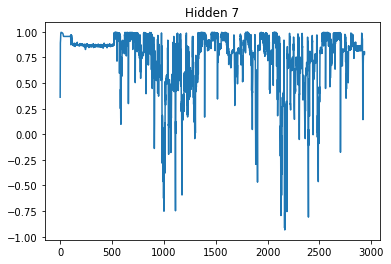

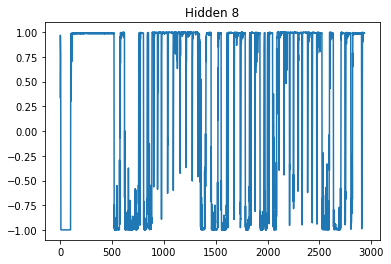

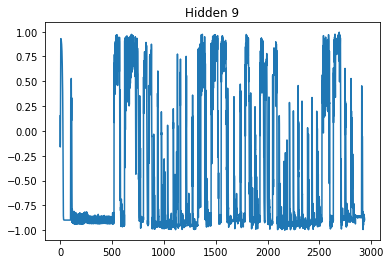

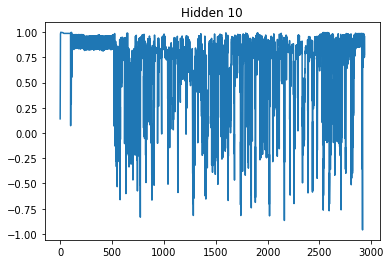

Param 0 loss = 6.123087406158447


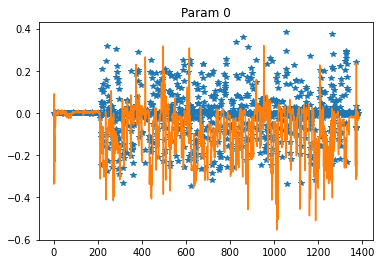

Param 1 loss = 2.755464792251587


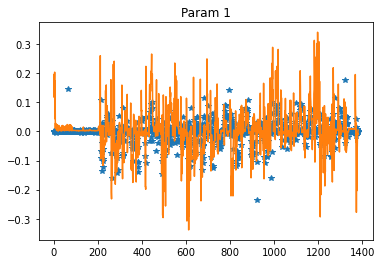

Param 2 loss = 17.528535842895508


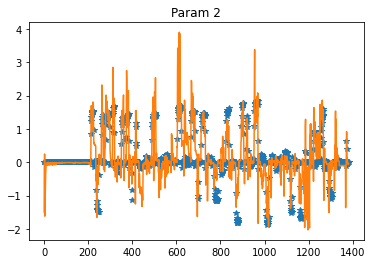

Param 3 loss = 7.713680267333984


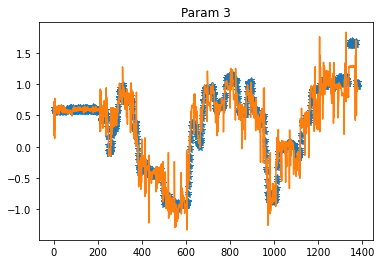

Param 4 loss = 8.4544677734375


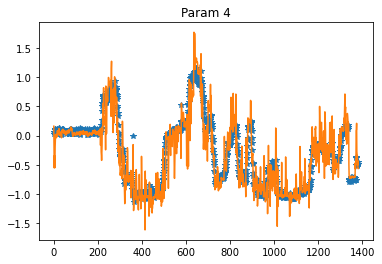

Param 5 loss = 7.71679162979126


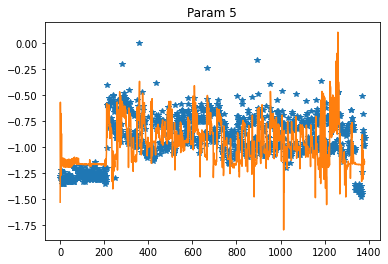

Param 6 loss = 7.439826965332031


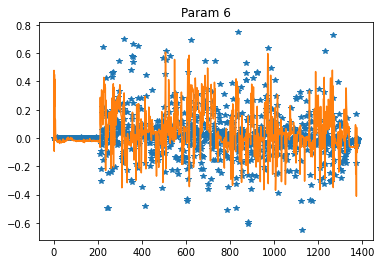

Param 7 loss = 14.117679595947266


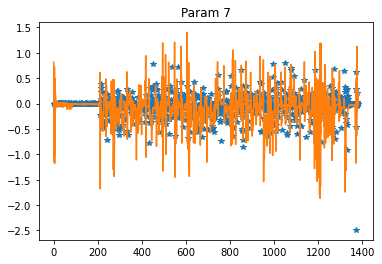

Param 8 loss = 23.98721694946289


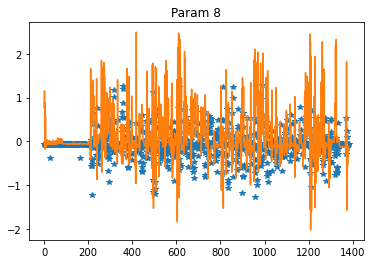

Param 9 loss = 13.095705032348633


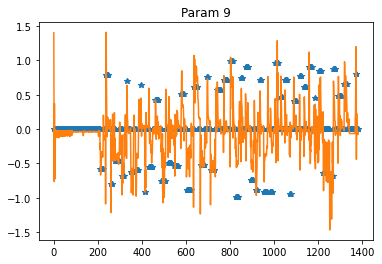

Param 10 loss = 18.806764602661133


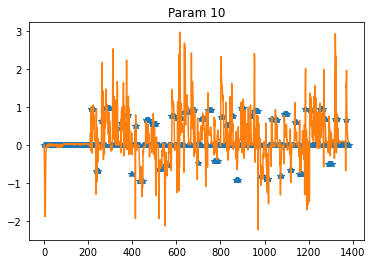

In [10]:
test_predictor(predictor,entries)